In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("unified_genotypes_preprocessed_final_v2 - unified_genotypes_preprocessed_final_v2.csv")
df = df.drop(columns=["patient_id", "risk"])
df.head()

,group,chr1_826893,chr1_941119,chr1_952421,chr1_953259,chr1_953279,chr1_961945,chr1_962184,chr1_979847,chr1_1013466,...,chrX_143629567,chrX_145823364,chrX_150762633,chrX_151700795,chrX_152850288,chrX_153776089,chrX_154412069,chrX_156023167,chrX_156023436,vaccination
0,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,0,1,1,1,1,0.0
1,0,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,0,0,0.0
2,1,1,1,1,1,1,1,1,0,0,...,2,2,2,2,2,2,2,1,1,0.0
3,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,0,0,0.0
4,1,0,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,1,1,0.0


In [3]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

def feature_selection(X, y, n_features_to_select, verbose=False):
    estimator = SVC(kernel="linear", random_state=42)
    selector = RFE(estimator, n_features_to_select=n_features_to_select, step=1, verbose=verbose)
    selector = selector.fit(X, y)
    return X.columns[selector.support_]

In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["group"])
y = df["group"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
selected_features = feature_selection(X, y, n_features_to_select=30)
X_train, X_test = X_train[selected_features], X_test[selected_features]
selected_features

Index(['chr1_1337736', 'chr1_45332883', 'chr1_179635729', 'chr1_197122407',
       'chr2_29320797', 'chr3_33097052', 'chr4_186156052', 'chr5_71510884',
       'chr5_151027895', 'chr6_24825283', 'chr7_1838741', 'chr7_28957328',
       'chr8_22162781', 'chr9_66917806', 'chr9_114424397', 'chr10_17907664',
       'chr10_48451516', 'chr10_69382664', 'chr10_133268842', 'chr11_93675665',
       'chr11_120228949', 'chr12_94277967', 'chr12_121857429', 'chr17_1012128',
       'chr17_10415319', 'chr19_43577136', 'chr19_53408720', 'chr19_53408989',
       'chr22_46535896', 'vaccination'],
      dtype='object')

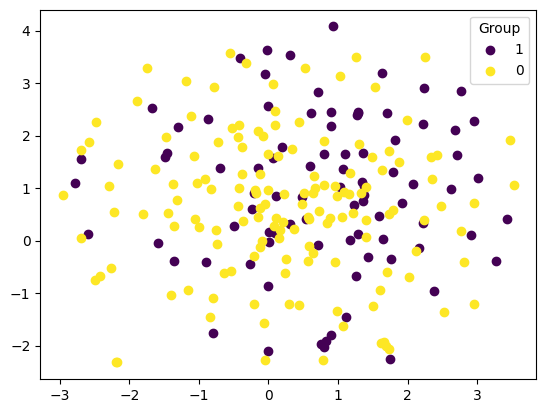

In [6]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def plot_tsne(X, y):
    X_scaled = StandardScaler().fit_transform(X)
    X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)
    
    plt.figure()
    unique_labels = y.unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
    for i, label in enumerate(unique_labels):
        X_label = X_embedded[y == label]
        plt.scatter(X_label[:, 0], X_label[:, 1], color=colors[i], label=label)
    plt.legend(title='Group')
    plt.show()

plot_tsne(X, y)

In [7]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline

baseline_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=42))
])

baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(random_state=42))])

In [8]:
from sklearn.model_selection import GridSearchCV, LeaveOneOut

param_grid = {
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1]
}

grid_search = GridSearchCV(baseline_pipeline, param_grid, cv=LeaveOneOut(), n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10, 100],
                         'svc__gamma': [0.001, 0.01, 0.1, 1],
                         'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid']})

,Accuracy,Precision,Recall,Specificity,F1
Baseline,0.893617,0.928571,0.764706,0.966667,0.838710
Tuned,0.936170,0.937500,0.882353,0.966667,0.909091


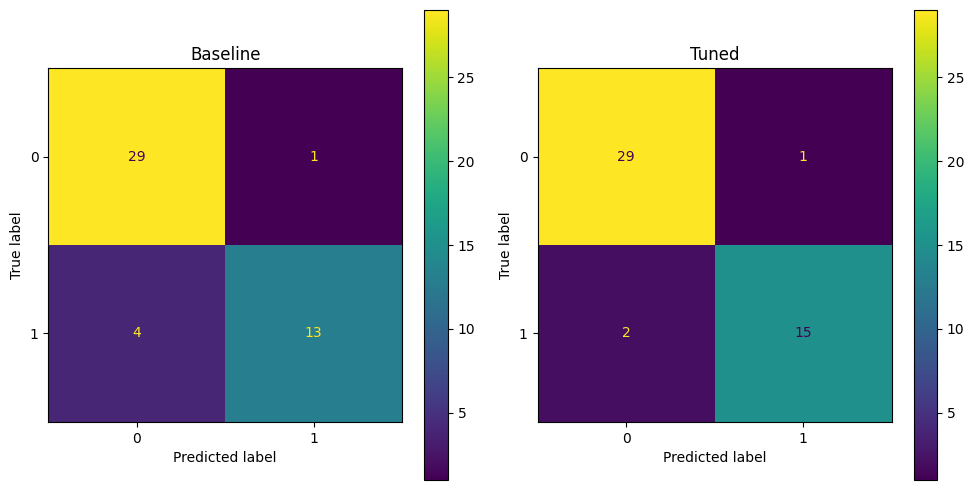

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display


def evaluate_model(model, X_test, y_test, ax, title):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=ax)
    ax.set_title(title)
    
    return accuracy, precision, recall, specificity, f1


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
baseline_scores = evaluate_model(baseline_pipeline, X_test, y_test, axes[0], "Baseline")
grid_search_scores = evaluate_model(grid_search, X_test, y_test, axes[1], "Tuned")

df_scores = pd.DataFrame([baseline_scores, grid_search_scores],
                         columns=["Accuracy", "Precision", "Recall", "Specificity", "F1"])
df_scores.index = ["Baseline", "Tuned"]

display(df_scores)
plt.tight_layout()
plt.show()